In [ ]:
pip install tensorflow tensorflow-gpu opencv-python matplotlib


In [13]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt
import torch

In [18]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

print(tf.__version__)


2.13.0-rc1


In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

gpus


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [14]:
# Set up data strcutures
# Verification Images
POS_PATH = os.path.join('data', 'positive')
# Non verification images
NEG_PATH = os.path.join('data', 'negative')
#Actual input images
ANC_PATH = os.path.join('data', 'anchor')

In [ ]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [ ]:
# Uncompress the dataset -> using the labeled faces in the wild dataset
!tar -xf lfw.tgz

In [ ]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [ ]:
# Import uuid library to generate unique image names
import uuid

os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

### 3. Load the Webcam and Setup anchor image collection

In [63]:
import uuid
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data/anchor/03281cfe-18f7-11ee-9d7d-f2b4706f8c9e.jpg'

In [67]:
 # Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+500,200:200+500, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

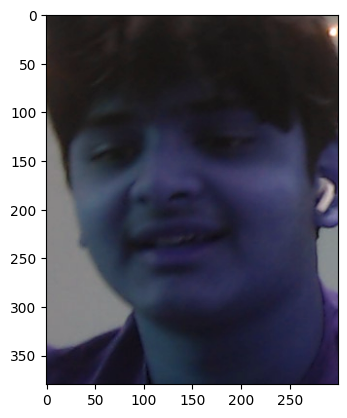

In [11]:
plt.imshow(frame[120:120+500,200:200+500, :])

### Create dataset and process it

In [21]:
# Path to the positive images directory
positive_dir = './data/positive/'

# Pattern for positive images
positive_pattern = positive_dir + '*.jpg'

# Path to the negative images directory
negative_dir = './data/negative/'

# Pattern for negative images
negative_pattern = negative_dir + '*/*.jpg'

# Convert positive images into a dataset
positive = tf.data.Dataset.list_files(positive_pattern).take(300)

# Convert negative images into a dataset
negative = tf.data.Dataset.list_files(negative_pattern).take(300)

# Extract the class names from the positive subdirectories
positive_class_names = [name for name in os.listdir(positive_dir) if os.path.isdir(os.path.join(positive_dir, name))]

# Extract the class names from the negative subdirectories
negative_class_names = [name for name in os.listdir(negative_dir) if os.path.isdir(os.path.join(negative_dir, name))]


# Convert into datasets
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)



In [22]:
dir_test = anchor.as_numpy_iterator()
print(dir_test.next())

b'data/anchor/260a04a4-18f1-11ee-be82-f2b4706f8c9e.jpg'


In [93]:
# Main Preprocesssing Function
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
        # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    
    return img

In [75]:
img = preprocess('data/anchor/0a2a127e-18f1-11ee-be82-f2b4706f8c9e.jpg')


In [27]:
img.numpy().max() 

1.0

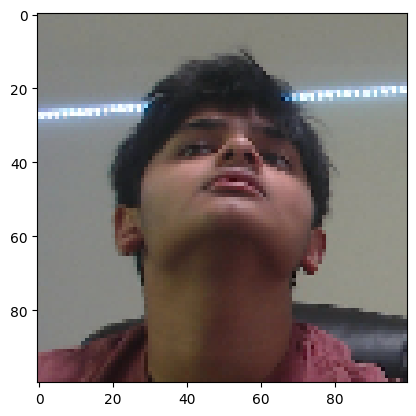

In [28]:
plt.imshow(img)

In [ ]:
#dataset.map(preprocess)

#### Create the actual Dataset

In [29]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [30]:
# Get the testing dir
samples = data.as_numpy_iterator()
example = samples.next()
example

(b'data/anchor/260a04a4-18f1-11ee-be82-f2b4706f8c9e.jpg',
 b'./data/positive/4fec1794-18f1-11ee-be82-f2b4706f8c9e.jpg',
 1.0)

#### Partion the dataset

1.0

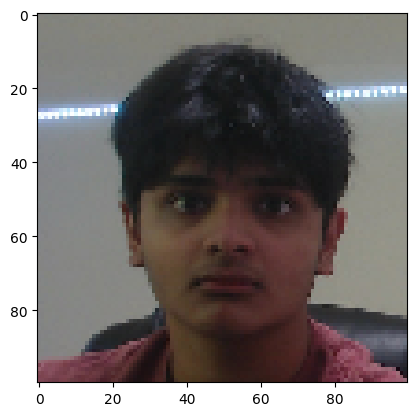

In [31]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

res = preprocess_twin(*example)


plt.imshow(res[1])
res[2]

In [32]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [33]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

### Build the whole Siamese model
The goal is to compare and measure the similarity or dissimilarity between two inputs

In [34]:
# Embedding Layer
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

embedding = make_embedding()
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2  (None, 46, 46, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 20, 20, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [35]:
# 4.2 Build Distance Layer

# Siamese L1 Distance class - custom layer
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)
    
l1 = L1Dist()
l1

In [36]:
# Main siamese model
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)
distances

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'l1_dist_1')>

In [37]:

classifier = Dense(1, activation='sigmoid')(distances)

classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_1')>

In [38]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [39]:
# SiameseModel
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100, 100, 3))  # Update the shape here
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100, 100, 3))  # Update the shape here
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


siamese_model = make_siamese_model()
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

In [40]:
# Traning and loss

binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [41]:
test_batch = train_data.as_numpy_iterator()
batch_1 = test_batch.next()
len(batch_1[0])

16

In [42]:
y = batch_1[2]
y

array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.],
      dtype=float32)

In [43]:

@tf.function
def train_step(batch):
    
    # Allows to capture gradients -> records everythign that happens inside the neural network - relates to diffrentiation
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2] 
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss



In [44]:

# Build Training Loop
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)
            
EPOCHS = 50
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)


2023-07-02 09:11:13.972238: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-07-02 09:11:14.029763: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


3/3 [==============================] - 8s 2s/step

 Epoch 2/50
3/3 [==============================] - 6s 2s/step

 Epoch 3/50
3/3 [==============================] - 6s 2s/step

 Epoch 4/50
3/3 [==============================] - 6s 2s/step

 Epoch 5/50
3/3 [==============================] - 6s 2s/step

 Epoch 6/50
3/3 [==============================] - 6s 2s/step

 Epoch 7/50
3/3 [==============================] - 6s 2s/step

 Epoch 8/50
3/3 [==============================] - 6s 2s/step

 Epoch 9/50
3/3 [==============================] - 6s 2s/step

 Epoch 10/50
3/3 [==============================] - 6s 2s/step

 Epoch 11/50
3/3 [==============================] - 4s 2s/step

 Epoch 12/50
3/3 [==============================] - 6s 2s/step

 Epoch 13/50
3/3 [==============================] - 6s 2s/step

 Epoch 14/50
3/3 [==============================] - 6s 2s/step

 Epoch 15/50
3/3 [==============================] - 6s 2s/step

 Epoch 16/50
3/3 [==============================] - 6s 2s/ste

#### Evaluate and Test the model

In [45]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [46]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 [==============================] - 0s 179ms/step


2023-07-02 09:19:56.350675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([[9.9960560e-01],
       [9.9999928e-01],
       [4.3664942e-05],
       [3.9869242e-08],
       [9.9999988e-01],
       [1.7062969e-04],
       [5.5364154e-08],
       [5.9435090e-10],
       [9.9931598e-01],
       [1.7119988e-06],
       [9.9995482e-01],
       [9.9976140e-01],
       [8.7326901e-09],
       [5.6778576e-06],
       [1.8833413e-04],
       [1.2590618e-07]], dtype=float32)

In [47]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0]

In [48]:
y_true

array([1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.],
      dtype=float32)

In [49]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [50]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

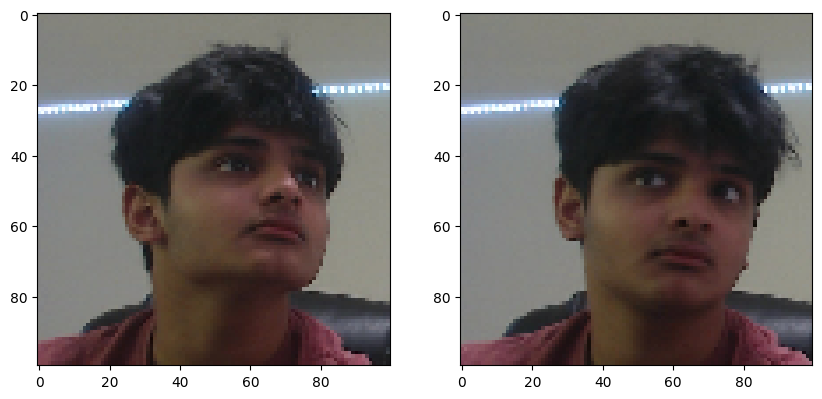

In [52]:
# Show the results

# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

In [53]:
# Save weights
siamese_model.save('siamesemodel.h5')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [54]:
L1Dist

__main__.L1Dist

In [55]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [56]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 [==============================] - 0s 97ms/step


2023-07-02 09:22:30.051458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


array([[9.9960560e-01],
       [9.9999928e-01],
       [4.3664942e-05],
       [3.9869242e-08],
       [9.9999988e-01],
       [1.7062969e-04],
       [5.5364154e-08],
       [5.9435090e-10],
       [9.9931598e-01],
       [1.7119988e-06],
       [9.9995482e-01],
       [9.9976140e-01],
       [8.7326901e-09],
       [5.6778576e-06],
       [1.8833413e-04],
       [1.2590618e-07]], dtype=float32)

In [57]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_img (InputLayer)      [(None, 100, 100, 3)]        0         []                            
                                                                                                  
 validation_img (InputLayer  [(None, 100, 100, 3)]        0         []                            
 )                                                                                                
                                                                                                  
 embedding (Functional)      (None, 4096)                 3896044   ['input_img[0][0]',           
                                                          8          'validation_img[0][0]']      
                                                                                     

### Realtime OpenCV test

In [74]:
# Main Verfication Function

def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [100]:
import time

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+500,200:200+500, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        
        # Measure the start time
        start_time = time.time()
        
        # Run verification
        results, verified = verify(model, 0.5, 0.5)
        
        # Measure the end time
        end_time = time.time()
        
        # Calculate the elapsed time
        elapsed_time = end_time - start_time
        
        print("Verification Result:", verified)
        print("Elapsed Time:", elapsed_time, "seconds")
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 12ms/step
Verification Result: True
Elapsed Time: 2.1822736263275146 seconds
1/1 [==============================] - 0s 12ms/step
Verification Result: True
Elapsed Time: 2.2034659385681152 seconds
1/1 [==============================] - 0s 12ms/step
Verification Result: False
Elapsed Time: 2.1949727535247803 seconds
1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 12ms/step
Verification Result: True
Elapsed Time: 2.234980821609497 seconds
1/1 [==============================] - 0s 14ms/step
Verification Result: True
Elapsed Time: 2.1803927421569824 seconds
1/1 [==============================] - 0s 12ms/step
Verification Result: True
Elapsed Time: 2.1858601570129395 seconds
1/1 [==============================] - 0s 12ms/step
Verification Result: True
Elapsed Time: 0.3298971652984619 seconds
1/1 [==============================] - 0s 12ms/step
Verification Result: True
Elapsed Time: 0.2296922206878662 seconds
1/1 [==============================] - 0s 12ms/step
Verification Result: True
Elapsed Time: 0.2231910228729248 seconds
1/1 [==============================] - 0s 12ms/step
Verification Result: False
Elapsed Time: 0.22801780700683594 seconds
1/1 [==============================] - 0s 12ms/step
Verification Result: False
Elapsed Time: 0.22699594497680664 seconds
1/1 [==============================] - 0s 15m

InvalidArgumentError: {{function_node __wrapped__DecodeJpeg_device_/job:localhost/replica:0/task:0/device:CPU:0}} Unknown image file format. One of JPEG, PNG, GIF, BMP required. [Op:DecodeJpeg]

In [87]:
results

[array([[0.99999905]], dtype=float32),
 array([[0.9999999]], dtype=float32),
 array([[0.99996424]], dtype=float32),
 array([[0.999998]], dtype=float32),
 array([[0.99996567]], dtype=float32),
 array([[0.9999703]], dtype=float32),
 array([[0.9999937]], dtype=float32),
 array([[0.9998223]], dtype=float32),
 array([[0.9999825]], dtype=float32),
 array([[0.999985]], dtype=float32),
 array([[0.99999905]], dtype=float32),
 array([[0.9997502]], dtype=float32),
 array([[0.99999964]], dtype=float32),
 array([[0.9980976]], dtype=float32)]

In [92]:
np.sum(np.squeeze(results) > 0.5)

14

In [ ]:
`